In [1]:
import json
import numpy as np
import dicom
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Path where the min / max per slice per patient is located
path = '/masvol/output/dsb/volume/1/3/'

In [3]:
# Function to ge the volume. If v_type is None then the V = (Area_i + Area_i+1)((L_i - L_i+1)/2) is
# used, otherwise, it is V = (Area_i + Area_i+1 + np.sqrt(Area_i * Area_i+1))((L_i - L_i+1)/3)
def getVolume(patient,patientdict, v_type = None):
    es= {}
    ed = {}
    noSL = []
    noMin = []
    noMax = []
    numSlices = 0
    issues = {}
    for i in patientdict:
        numSlices = len(patientdict.keys())
        if len(patientdict.keys()) < 5:
             print ('Less than five slices')    

        if patientdict[i]['minSL'] is None: 
#             print ('MinSL: ', patientdict[i])
            noSL.append(patientdict[i]['zminframe'])
        else: 
            if patientdict[i]['zmin'] ==0:
#                 print ('zmin: ', patientdict[i])
                noMin.append(patientdict[i]['zminframe'])
            es[patientdict[i]['minSL']] = {'zmin': patientdict[i]['zmin'],
                                          'minST':patientdict[i]['minST']}
    
        if patientdict[i]['maxSL'] is None:
#             print ('MaxSL: ', patientdict[i])
            noSL.append(patientdict[i]['zmaxframe'])
        else:
            if patientdict[i]['zmax'] ==0:
#                 print ('zmax: ', patientdict[i])
                noMax.append(patientdict[i]['zmaxframe'])
            ed[patientdict[i]['maxSL']] = {'zmax': patientdict[i]['zmax'],
                                          'maxST':patientdict[i]['maxST']}
    
    ESV=0
    a = sorted(es)
#     print (a)
    for i in range(len(a)-1):
        if v_type is None:
            if (i+1) == (len(a)-1):
#                 ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin']) * ((abs(a[i]-a[i+1]-(es[a[i+1]]['minST'])))/2)
                ESVi = ((es[a[i]]['zmin'] + es[a[i+1]]['zmin']) * ((abs(a[i]-a[i+1]))/2)) + (es[a[i+1]]['zmin'] * es[a[i+1]]['minST'])
                print ('ESVi:', ESVi)
            else:
                ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin']) * ((abs(a[i]-a[i+1]))/2)
                print ('ESVi:', ESVi)
        else: 
            if (i+1) == (len(a)-1):
                 ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin'] + np.sqrt(es[a[i]]['zmin'] * es[a[i+1]]['zmin'])) * ((abs(a[i]-a[i+1]-(es[a[i+1]]['minST'])))/3)
            else:
                ESVi = (es[a[i]]['zmin'] + es[a[i+1]]['zmin'] + np.sqrt(es[a[i]]['zmin'] * es[a[i+1]]['zmin'])) * ((abs(a[i]-a[i+1]))/3)
            
        ESV = ESV + ESVi
    ESV = ESV/1000
    EDV=0
    b = sorted(ed)
    for i in range(len(b)-1):
        if v_type is None:
            if (i+1) == (len(b)-1):
#                 EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax']) * ((abs(b[i]-b[i+1]-(ed[b[i+1]]['maxST']/2))))
#                 print( 'EDVi:', EDVi, 'height, ST:', (abs(b[i]-b[i+1]-(ed[b[i+1]]['maxST']))))
                EDVi = ((ed[b[i]]['zmax'] + ed[b[i+1]]['zmax']) * ((abs(b[i]-b[i+1]))/2)) + (ed[b[i+1]]['zmax'] * ed[b[i+1]]['maxST'])
            else:
                EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax']) * ((abs(b[i]-b[i+1]))/2)
                print ('EDVi:', EDVi, 'height, ST:', (abs(b[i]-b[i+1])), ed[b[i]]['maxST'], ed[b[i+1]]['maxST'])
        else:
            if (i+1) == (len(b)-1):
                EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax'] + np.sqrt(ed[b[i]]['zmax'] * ed[b[i+1]]['zmax'])) * ((abs(b[i]-b[i+1]-(ed[b[i+1]]['maxST'])))/3)
            else:
                EDVi = (ed[b[i]]['zmax'] + ed[b[i+1]]['zmax'] + np.sqrt(ed[b[i]]['zmax'] * ed[b[i+1]]['zmax'])) * ((abs(b[i]-b[i+1]))/3)
        EDV = EDV + EDVi
    EDV = EDV/1000
    
    issues[patient] = {'numSlices': numSlices,
                        'noMinValue': noMin,
                       'noMaxValue': noMax,
                       'noSL': noSL}
    return (ESV, EDV, issues)

In [4]:
test = json.load(open('/masvol/output/dsb/volume/1/3/validate_502_176.json'))
print(test)
getVolume('502',test)

{'sax_9': {'zmaxframe': 'IM-5144-0030.dcm.npy', 'zmax': 2494, 'minSL': -55.99352141463342, 'maxSL': -55.99352141463342, 'minST': 8.0, 'maxST': 8.0, 'zmin': 1431, 'zminframe': 'IM-5144-0011.dcm.npy'}, 'sax_6': {'zmaxframe': 'IM-5141-0001.dcm.npy', 'zmax': 2728, 'minSL': -25.99353139141475, 'maxSL': -25.99353139141475, 'minST': 8.0, 'maxST': 8.0, 'zmin': 1484, 'zminframe': 'IM-5141-0013.dcm.npy'}, 'sax_8': {'zmaxframe': 'IM-5143-0030.dcm.npy', 'zmax': 2689, 'minSL': -45.993526165507916, 'maxSL': -45.993526165507916, 'minST': 8.0, 'maxST': 8.0, 'zmin': 1323, 'zminframe': 'IM-5143-0011.dcm.npy'}, 'sax_12': {'zmaxframe': 'IM-5147-0001.dcm.npy', 'zmax': 2164, 'minSL': -85.99351988346322, 'maxSL': -85.99351988346322, 'minST': 8.0, 'maxST': 8.0, 'zmin': 1491, 'zminframe': 'IM-5147-0012.dcm.npy'}, 'sax_10': {'zmaxframe': 'IM-5145-0030.dcm.npy', 'zmax': 2829, 'minSL': -65.99352012862146, 'maxSL': -65.99352012862146, 'minST': 8.0, 'maxST': 8.0, 'zmin': 1939, 'zminframe': 'IM-5145-0011.dcm.npy'}, 

(107.39998335711114,
 212.49397048409173,
 {'502': {'noMaxValue': [],
   'noMinValue': ['IM-5140-0010.dcm.npy'],
   'noSL': [],
   'numSlices': 10}})

In [5]:
# For each patient, gets the volume 
ignorelist = ['roi']
Volumes = {}
Volumes2 = {}
for root, dirs, files in os.walk(path):   

    for i in files:
        if os.path.isfile(root+i):
            if ('_176.') in i:
                split = i.split('_')#.strip('.json')
#             print (split)
                source = split[0]
                patient = split[1].strip('.json')
#             print (source, patient)
                print (i)
                patientdict = json.load(open(root + i))
            #print (patientdict)
        
                ESV, EDV, issues = getVolume(patient, patientdict)
#         # Get volume using V = (Area_i + Area_i+1 + np.sqrt(Area_i * Area_i+1))((L_i - L_i+1)/3)
                #print (ESV, EDV, issues)   
                ESV2, EDV2, issues2 = getVolume(patient, patientdict, v_type=1)
        
                Volumes[source+'_'+patient] = {'ESV': ESV, 
                                              'EDV': EDV,
                                               'issues': issues}
#                 print (Volumes)
                Volumes2[source+'_'+patient] = {'ESV': ESV2, 
                                               'EDV': EDV2,
                                               'issues': issues2}

validate_501_176.json
ESVi: 8775.000271054163
ESVi: 12460.003538607465
ESVi: 14555.004631899668
ESVi: 16535.005262005598
ESVi: 18900.008151000824
ESVi: 19475.005414765656
ESVi: 15270.004245617889
ESVi: 9900.003796556772
EDVi: 13130.000405577339 height, ST: 10.000000308893632 8.0 8.0
EDVi: 19770.005614628375 height, ST: 10.000002839973888 8.0 8.0
EDVi: 24525.00780469525 height, ST: 10.00000318234261 8.0 8.0
EDVi: 28520.00907604473 height, ST: 10.000003182343875 8.0 8.0
EDVi: 31710.01367556805 height, ST: 10.000004312698849 8.0 8.0
EDVi: 34370.00955612301 height, ST: 10.000002780367474 8.0 8.0
EDVi: 34770.00966733032 height, ST: 10.00000278036535 8.0 8.0
validate_502_176.json
ESVi: 1009.9998116947024
ESVi: 8414.998324629127
ESVi: 15769.999906454128
ESVi: 18009.999665303323
ESVi: 16849.99783306984
ESVi: 13769.99345804582
ESVi: 12674.999397889975
ESVi: 13479.993595828133
ESVi: 7420.00136419609
EDVi: 4484.999163812614 height, ST: 9.999998135591113 8.0 8.0
EDVi: 14489.997115136784 height, ST

EDVi: 37439.99140021805 height, ST: 9.999997703049694 8.0 8.0
validate_535_176.json
ESVi: 3494.998997955282
ESVi: 2304.99965448968
ESVi: 1939.9988869205386
ESVi: 7104.998934988776
ESVi: 10434.999183601627
ESVi: 8299.995024939928
ESVi: 7844.999092391508
ESVi: 8014.9987985838425
ESVi: 14849.997101789322
EDVi: 6589.998110593793 height, ST: 9.999997132919262 8.0 8.0
EDVi: 8404.998740123974 height, ST: 9.999998501039826 8.0 8.0
EDVi: 11754.993255541716 height, ST: 9.999994262477003 8.0 8.0
EDVi: 16859.9974727531 height, ST: 9.999998501039798 8.0 8.0
EDVi: 22144.998267451654 height, ST: 9.999999217634524 8.0 8.0
EDVi: 23974.98562926925 height, ST: 9.99999400595172 8.0 8.0
EDVi: 22019.99745244882 height, ST: 9.999998843073943 8.0 8.0
EDVi: 19069.997141483953 height, ST: 9.999998501040352 8.0 8.0
validate_536_176.json
ESVi: 4234.997404725427
ESVi: 15474.993724177744
ESVi: 23260.00236577732
ESVi: 12159.995068567729
ESVi: 6250.000896026977
ESVi: 8099.995875635607
ESVi: 9340.001823000699
ESVi: 79

ESVi: 1492.9802123906702
ESVi: 2439.8698381483287
ESVi: 5295.568281801573
ESVi: 8316.600370155322
ESVi: 9043.05040247824
ESVi: 9017.99672180092
ESVi: 6277.530238304997
ESVi: 1497.9900174857503
EDVi: 6948.870988543153 height, ST: 10.02000142544074 6.0 6.0
EDVi: 10265.489319026541 height, ST: 10.019999335311411 6.0 6.0
EDVi: 15310.555032342107 height, ST: 10.019996748914991 6.0 6.0
EDVi: 18987.900845113658 height, ST: 10.020000445970268 6.0 6.0
EDVi: 20651.220919122054 height, ST: 10.020000445959269 6.0 6.0
EDVi: 23181.261573207146 height, ST: 10.019996357556579 6.0 6.0
EDVi: 23752.410901679163 height, ST: 10.020000380375095 6.0 6.0
validate_564_176.json
ESVi: 0.0
ESVi: 2159.999810704167
ESVi: 5550.000567012709
ESVi: 8820.0000354932
ESVi: 11190.001360703945
ESVi: 11689.998492492054
ESVi: 12409.998399635895
ESVi: 13375.00062348334
ESVi: 6895.000152247355
ESVi: 0.0
EDVi: 3834.9993966772786 height, ST: 9.99999842679864 8.0 8.0
EDVi: 7464.9993457900955 height, ST: 9.999999123630403 8.0 8.0
E

ESVi: 3920.0011656571623
ESVi: 9299.995456572857
ESVi: 14270.0041462768
ESVi: 18294.993871991544
ESVi: 18685.00576805503
ESVi: 14434.998767470463
ESVi: 10669.999859924115
ESVi: 6599.9999133576075
ESVi: 1764.9997212210678
EDVi: 11830.00357143844 height, ST: 10.000003018967405 8.0 8.0
EDVi: 11895.003537115292 height, ST: 10.00000297361521 8.0 8.0
EDVi: 15804.992278616559 height, ST: 9.99999511459447 8.0 8.0
EDVi: 19965.005801010255 height, ST: 10.00000290558991 8.0 8.0
EDVi: 25404.991490458877 height, ST: 9.99999665044632 8.0 8.0
EDVi: 28915.008926053586 height, ST: 10.000003086997609 8.0 8.0
EDVi: 27394.997660883502 height, ST: 9.999999146152035 8.0 8.0
EDVi: 23584.999690375844 height, ST: 9.999999868719883 8.0 8.0
EDVi: 17334.999772432446 height, ST: 9.999999868723648 8.0 8.0
validate_592_176.json
ESVi: 0.0
ESVi: 3630.000998512268
ESVi: 7644.998250118508
ESVi: 9540.000475101306
ESVi: 12445.002934137026
ESVi: 14579.998980941855
ESVi: 14889.99806816149
ESVi: 14130.001727257408
ESVi: 6899

validate_623_176.json
ESVi: 1089.99960533883
ESVi: 5155.000666405241
ESVi: 8529.996714545527
ESVi: 12354.995241276778
ESVi: 13229.996533567328
ESVi: 9414.99861422145
ESVi: 5329.998603472457
ESVi: 979.9995069932025
EDVi: 7004.997463668353 height, ST: 9.999996379255322 8.0 8.0
EDVi: 14100.001822757302 height, ST: 10.000001292735675 8.0 8.0
EDVi: 23204.99106225427 height, ST: 9.999996148353489 8.0 8.0
EDVi: 28004.989213432305 height, ST: 9.999996148342191 8.0 8.0
EDVi: 26984.992929577802 height, ST: 9.999997379869484 8.0 8.0
EDVi: 23254.99657713434 height, ST: 9.999998528116251 8.0 8.0
EDVi: 20649.99458943832 height, ST: 9.999997379873278 8.0 8.0
validate_624_176.json
ESVi: 711.4199089262073
ESVi: 2730.4501368295273
ESVi: 2494.980125029695
ESVi: 475.9500325625113
ESVi: 2464.9201235233095
ESVi: 5651.280025637578
ESVi: 7359.690368812494
ESVi: 7590.149945151433
ESVi: 3416.8198603503065
EDVi: 6758.489134798969 height, ST: 10.019998717270525 6.0 6.0
EDVi: 13757.460689419968 height, ST: 10.0200

ESVi: 0.0
ESVi: 0.0
EDVi: 3795.000707232049 height, ST: 10.000001863589063 8.0 8.0
EDVi: 7990.005928644087 height, ST: 10.000007420080209 8.0 8.0
EDVi: 12360.002164411206 height, ST: 10.000001751141752 8.0 8.0
EDVi: 17155.00997147621 height, ST: 10.000005812577214 8.0 8.0
EDVi: 22465.004186552895 height, ST: 10.000001863589091 8.0 8.0
EDVi: 27210.012936439667 height, ST: 10.000004754296093 8.0 8.0
EDVi: 29960.009090846677 height, ST: 10.000003034327996 8.0 8.0
EDVi: 30220.014367482792 height, ST: 10.000004754296093 8.0 8.0
EDVi: 29105.007127707417 height, ST: 10.000002448963208 8.0 8.0
EDVi: 27060.00662688556 height, ST: 10.000002448959926 8.0 8.0
EDVi: 22300.008684321707 height, ST: 10.000003894314666 8.0 8.0
EDVi: 9790.004300705741 height, ST: 10.000004392957855 8.0 8.0
validate_651_176.json
ESVi: 353.99997709122175
ESVi: 884.9995428585444
ESVi: 1277.9999107925703
ESVi: 1704.0006769880636
ESVi: 2561.999716871047
ESVi: 3512.9998977930645
ESVi: 3476.999898843715
ESVi: 2858.99945127518


ESVi: 1404.999344548021
ESVi: 5809.99972250766
ESVi: 9930.002855076587
ESVi: 11139.996891614857
ESVi: 8579.99973131944
ESVi: 6135.001004075153
ESVi: 3169.999785691267
EDVi: 5314.9975204788125 height, ST: 9.99999533486136 8.0 8.0
EDVi: 12429.999406328781 height, ST: 9.9999995223884 8.0 8.0
EDVi: 18885.00542982088 height, ST: 10.000002875203009 8.0 8.0
EDVi: 20974.994147362802 height, ST: 9.99999720970813 8.0 8.0
EDVi: 21649.99932203565 height, ST: 9.999999686852494 8.0 8.0
EDVi: 21125.003457389994 height, ST: 10.000001636634316 8.0 8.0
validate_669_176.json
ESVi: 1619.9985867455453
ESVi: 3789.9979199110417
ESVi: 7619.993352469776
ESVi: 9699.995157565747
ESVi: 8969.997114571972
ESVi: 8859.99137429525
ESVi: 7614.996968896034
ESVi: 14956.99475706207
EDVi: 6899.993980582878 height, ST: 9.99999127620707 8.0 8.0
EDVi: 9864.99458573151 height, ST: 9.999994511638633 8.0 8.0
EDVi: 14244.98757295695 height, ST: 9.999991276207055 8.0 8.0
EDVi: 18839.99059469471 height, ST: 9.99999500779974 8.0 8.0

validate_695_176.json
ESVi: 0.0
ESVi: 604.9999308145298
ESVi: 2545.0010181851417
ESVi: 8224.999059420135
ESVi: 11804.998650027304
ESVi: 12075.004830864404
ESVi: 12024.999412388033
ESVi: 10885.004213787905
ESVi: 10919.998930027978
ESVi: 19103.004401003833
EDVi: 2239.9997438413347 height, ST: 9.99999885643453 8.0 8.0
EDVi: 6499.999256685031 height, ST: 9.99999885643851 8.0 8.0
EDVi: 10490.004196763119 height, ST: 10.000004000727472 8.0 8.0
EDVi: 17004.998055372573 height, ST: 9.999998856437855 8.0 8.0
EDVi: 21784.997508754324 height, ST: 9.999998856439902 8.0 8.0
EDVi: 23690.009477695876 height, ST: 10.000004000715862 8.0 8.0
EDVi: 25724.998742925753 height, ST: 9.9999995113414 8.0 8.0
EDVi: 25175.00974571525 height, ST: 10.000003871187786 8.0 8.0
EDVi: 23199.997726799367 height, ST: 9.99999902017214 8.0 8.0
validate_696_176.json
ESVi: 1092.1800017945664
ESVi: 4408.799896816638
ESVi: 8977.91975044201
ESVi: 12484.920029413113
ESVi: 13476.899674975431
ESVi: 13051.049913196455
ESVi: 11958.8

EDVi: 17375.002379944664 height, ST: 10.000001369752326 8.0 8.0
EDVi: 21744.99291066756 height, ST: 9.999996739787335 8.0 8.0
EDVi: 24655.005902405122 height, ST: 10.000002393999239 8.0 8.0
EDVi: 26880.007120257393 height, ST: 10.00000264890528 8.0 8.0
EDVi: 28819.990787727496 height, ST: 9.999996803514051 8.0 8.0
EDVi: 29589.996977532635 height, ST: 9.999998978551076 8.0 8.0
EDVi: 28344.999802179827 height, ST: 9.999999930209853 8.0 8.0
train_122_176.json
ESVi: 679.9998187000155
ESVi: 2499.999981681839
ESVi: 5050.002000186117
ESVi: 8159.998882303654
ESVi: 9799.998657668631
ESVi: 9595.000880994916
ESVi: 5204.999418778069
ESVi: 480.00006559532744
ESVi: 0.0
EDVi: 3359.9991041647822 height, ST: 9.999997333823757 8.0 8.0
EDVi: 9094.99993335853 height, ST: 9.999999926727355 8.0 8.0
EDVi: 14650.00580252012 height, ST: 10.000003960764587 8.0 8.0
EDVi: 20474.99719548619 height, ST: 9.999998630274085 8.0 8.0
EDVi: 24029.996708548693 height, ST: 9.999998630274114 8.0 8.0
EDVi: 22760.00208978054 

ESVi: 971.9400073283515
ESVi: 4498.979882267966
ESVi: 7750.469832351361
ESVi: 9298.55972051104
ESVi: 9834.631224659137
ESVi: 9759.479246425226
ESVi: 4999.997194238307
ESVi: 0.0
EDVi: 4974.930037510583 height, ST: 10.020000075550016 6.0 6.0
EDVi: 10766.489718255967 height, ST: 10.01999973779057 6.0 6.0
EDVi: 15390.719667086865 height, ST: 10.019999783259678 6.0 6.0
EDVi: 19208.3394226505 height, ST: 10.019999698826553 6.0 6.0
EDVi: 21132.18263148866 height, ST: 10.020001247742371 6.0 6.0
EDVi: 21407.72834700975 height, ST: 10.019999226309267 6.0 6.0
EDVi: 20736.461309571496 height, ST: 10.020034457391397 6.0 6.0
train_152_176.json
ESVi: 2304.998664710234
ESVi: 5335.000026964301
ESVi: 4985.00235546208
ESVi: 2839.995337658106
ESVi: 5980.003895070717
ESVi: 11875.000538125296
ESVi: 9639.991247330112
ESVi: 2355.0005281519825
ESVi: 0.0
EDVi: 10274.994047677943 height, ST: 9.999994206985832 8.0 8.0
EDVi: 16205.000081903747 height, ST: 10.000000050542269 8.0 8.0
EDVi: 21815.010307804467 height,

EDVi: 21270.004249539496 height, ST: 10.000001997902913 8.0 8.0
train_181_176.json
ESVi: 404.99987691254347
ESVi: 1879.999774424499
ESVi: 3974.9998372916048
ESVi: 5739.999651598158
ESVi: 8320.001025329186
ESVi: 9514.999234417239
ESVi: 9649.999604993862
ESVi: 8399.999219237903
ESVi: 3279.999606443358
EDVi: 4024.998776723426 height, ST: 9.999996960803543 8.0 8.0
EDVi: 8719.998953713633 height, ST: 9.999998800130314 8.0 8.0
EDVi: 13639.999441674841 height, ST: 9.999999590670704 8.0 8.0
EDVi: 16914.998973307116 height, ST: 9.999999393028151 8.0 8.0
EDVi: 19610.002416671312 height, ST: 10.00000123236681 8.0 8.0
EDVi: 20429.998356189615 height, ST: 9.99999919539384 8.0 8.0
EDVi: 19644.99919586574 height, ST: 9.999999590667214 8.0 8.0
EDVi: 19614.998176827554 height, ST: 9.999999070521312 8.0 8.0
test_1000_176.json
ESVi: 0.0
ESVi: 834.9994569657653
ESVi: 3239.999540307811
ESVi: 6364.995239990824
ESVi: 7854.998052128595
ESVi: 7229.995712664999
ESVi: 8084.997995097657
ESVi: 18555.995358850898
E

train_197_176.json
ESVi: 545.0003559433297
ESVi: 2230.001254825017
ESVi: 3955.0032059405676
ESVi: 6530.003674442772
ESVi: 9120.006828923191
ESVi: 11755.0054898606
ESVi: 12610.012601482502
ESVi: 13685.006391215811
ESVi: 8935.00657762498
ESVi: 1095.0008381179337
ESVi: 130.00007837873838
EDVi: 5020.003278597275 height, ST: 10.00000653107027 8.0 8.0
EDVi: 9660.0054356994 height, ST: 10.000005627018012 8.0 8.0
EDVi: 14815.012009104807 height, ST: 10.000008106044419 8.0 8.0
EDVi: 18875.010620996527 height, ST: 10.000005627018027 8.0 8.0
EDVi: 21335.015975337312 height, ST: 10.000007487854376 8.0 8.0
EDVi: 27395.012794107286 height, ST: 10.000004670234453 8.0 8.0
EDVi: 30700.030679263506 height, ST: 10.000009993245442 8.0 8.0
EDVi: 30300.014150810308 height, ST: 10.000004670234425 8.0 8.0
EDVi: 34090.025095829384 height, ST: 10.000007361639597 8.0 8.0
EDVi: 27610.0211328184 height, ST: 10.000007654045056 8.0 8.0
test_1018_176.json
ESVi: 745.0003033911132
ESVi: 2404.999413297931
ESVi: 4820.002

ESVi: 880.00046721964
ESVi: 2950.0019881773037
ESVi: 6750.003246432
ESVi: 10915.006575687456
ESVi: 12265.006776002529
ESVi: 11185.006058897568
ESVi: 9565.004857451058
ESVi: 10105.005510630423
ESVi: 10215.005679677099
ESVi: 15999.004856332327
EDVi: 8435.005684839172 height, ST: 10.00000673958408 8.0 8.0
EDVi: 12155.005845982365 height, ST: 10.000004809528889 8.0 8.0
EDVi: 16300.00981985392 height, ST: 10.000006024450258 8.0 8.0
EDVi: 19120.010563160893 height, ST: 10.000005524665738 8.0 8.0
EDVi: 20945.011345874795 height, ST: 10.000005416984862 8.0 8.0
EDVi: 21670.011004805485 height, ST: 10.000005078359706 8.0 8.0
EDVi: 21995.011994687397 height, ST: 10.000005453370036 8.0 8.0
EDVi: 21700.012065491243 height, ST: 10.000005560134213 8.0 8.0
test_1033_176.json
ESVi: 2064.9998710546797
ESVi: 5399.999662809211
ESVi: 8965.001344360342
ESVi: 13164.995908558403
ESVi: 14615.001832078813
ESVi: 14245.000161817363
ESVi: 13219.996970186668
ESVi: 11930.000228537443
ESVi: 16131.99914523079
EDVi: 55

ESVi: 5259.993895538698
ESVi: 12595.003891814486
ESVi: 17234.99152574593
ESVi: 20895.003620931584
ESVi: 23399.988267778983
ESVi: 24675.006547877485
ESVi: 25719.987104576012
ESVi: 23729.988838028006
ESVi: 21530.00437832473
ESVi: 20679.990984275086
ESVi: 31584.99748281497
EDVi: 13849.983926465962 height, ST: 9.999988394560262 8.0 8.0
EDVi: 24300.007508621835 height, ST: 10.000003089967834 8.0 8.0
EDVi: 30779.984865823015 height, ST: 9.99999508311339 8.0 8.0
EDVi: 34430.005966435725 height, ST: 10.000001732917724 8.0 8.0
EDVi: 38129.98088249626 height, ST: 9.999994986230334 8.0 8.0
EDVi: 38600.010243082914 height, ST: 10.000002653648423 8.0 8.0
EDVi: 37419.98123846168 height, ST: 9.999994986227065 8.0 8.0
EDVi: 36819.982680834015 height, ST: 9.999995296261275 8.0 8.0
EDVi: 35820.007284328465 height, ST: 10.000002033592537 8.0 8.0
EDVi: 33599.985351626834 height, ST: 9.999995640365128 8.0 8.0
train_225_176.json
ESVi: 1219.998993384637
ESVi: 1994.9998885973253
ESVi: 2519.999859279564
ESVi: 

EDVi: 24660.0022407701 height, ST: 10.000000908665896 8.0 8.0
EDVi: 26264.997517146516 height, ST: 9.99999905469123 8.0 8.0
EDVi: 27570.001170966672 height, ST: 10.000000424724945 8.0 8.0
EDVi: 27190.004611860117 height, ST: 10.000001696160396 8.0 8.0
EDVi: 24269.996969024396 height, ST: 9.999998751143139 8.0 8.0
EDVi: 15479.998847924315 height, ST: 9.999999255765061 8.0 8.0
train_24_176.json
ESVi: 0.0
ESVi: 1279.999847086981
ESVi: 3292.001817948471
ESVi: 4132.00089409905
ESVi: 3772.000816203673
ESVi: 3772.0011294885844
ESVi: 5232.0015529628145
ESVi: 5288.001144234377
ESVi: 6964.000970376754
EDVi: 4579.999452858104 height, ST: 7.999999044293631 8.0 8.0
EDVi: 9964.005502441849 height, ST: 8.000004417857767 8.0 8.0
EDVi: 12012.00259920566 height, ST: 8.0000017310727 8.0 8.0
EDVi: 12532.002711735002 height, ST: 8.00000173107884 8.0 8.0
EDVi: 11836.003544174677 height, ST: 8.000002395521918 8.0 8.0
EDVi: 11032.003274519451 height, ST: 8.000002374560879 8.0 8.0
EDVi: 10408.002252116376 heig

ESVi: 1211.999970127497
ESVi: 3115.9981783644075
ESVi: 7284.003071783542
ESVi: 10435.999742781989
ESVi: 12427.998987803658
ESVi: 4689.510299591879
ESVi: 2726.853571441291
ESVi: 11807.999967944219
ESVi: 10952.001312106808
ESVi: 13447.99590337086
ESVi: 8868.003156963729
ESVi: 638.7002453332049
ESVi: 91.78552465408347
ESVi: 0.0
EDVi: 4655.999885242265 height, ST: 7.999999802821762 8.0 8.0
EDVi: 9775.994284881403 height, ST: 7.999995323143537 8.0 8.0
EDVi: 16328.006885788258 height, ST: 8.00000337373261 8.0 8.0
EDVi: 21055.999481028895 height, ST: 7.999999802822529 8.0 8.0
EDVi: 25115.99795443166 height, ST: 7.999999348441364 8.0 8.0
EDVi: 13541.619629158571 height, ST: 5.018202567781572 8.0 8.0
EDVi: 8460.849654417347 height, ST: 2.98179723503695 8.0 8.0
EDVi: 28379.999922955365 height, ST: 7.999999978281991 8.0 8.0
EDVi: 27484.003292726764 height, ST: 8.000000958441788 8.0 8.0
EDVi: 27991.9914728701 height, ST: 7.99999756298088 8.0 8.0
EDVi: 24428.00869624605 height, ST: 8.00000284796006

ESVi: 1415.000004879243
ESVi: 4034.9991900770087
ESVi: 7220.001118671055
ESVi: 10019.998682375868
ESVi: 11220.001427755022
ESVi: 9855.015483006886
ESVi: 9080.001658288253
ESVi: 15076.998720240343
EDVi: 6785.000023396229 height, ST: 10.000000034482284 8.0 8.0
EDVi: 11739.997643495437 height, ST: 9.999997992755908 8.0 8.0
EDVi: 16060.002488345866 height, ST: 10.000001549405894 8.0 8.0
EDVi: 20284.997332534378 height, ST: 9.999998685005856 8.0 8.0
EDVi: 22880.002911500436 height, ST: 10.000001272508932 8.0 8.0
EDVi: 22695.035655691656 height, ST: 10.000015710813685 8.0 8.0
EDVi: 21425.003912866276 height, ST: 10.000001826308647 8.0 8.0
train_27_176.json
ESVi: 2175.000483134288
ESVi: 7260.00178985434
ESVi: 11690.001176461281
ESVi: 15759.601473846426
ESVi: 17979.983446413855
ESVi: 16409.996413476136
ESVi: 14659.995281254487
ESVi: 12544.996533571286
ESVi: 12349.988780465039
ESVi: 6879.998516857182
EDVi: 6120.001359439927 height, ST: 10.00000222130707 8.0 8.0
EDVi: 12530.003089101223 height, 

ESVi: 7819.993774294572
ESVi: 10999.997599120648
ESVi: 12684.997535300317
ESVi: 12924.996422146678
ESVi: 13944.996998111188
ESVi: 12679.997232444317
ESVi: 13154.997759182213
ESVi: 7589.99615039708
ESVi: 0.0
EDVi: 4789.998724985277 height, ST: 9.999997338173856 8.0 8.0
EDVi: 11594.998024908818 height, ST: 9.999998296600964 8.0 8.0
EDVi: 18049.98562992545 height, ST: 9.999992038739862 8.0 8.0
EDVi: 21644.99527572422 height, ST: 9.999997817382408 8.0 8.0
EDVi: 25669.995012310534 height, ST: 9.999998056996702 8.0 8.0
EDVi: 28524.992103809203 height, ST: 9.999997231834953 8.0 8.0
EDVi: 28864.993786337716 height, ST: 9.999997847336815 8.0 8.0
EDVi: 29494.993562377374 height, ST: 9.999997817385108 8.0 8.0
EDVi: 28644.9951206214 height, ST: 9.999998296603735 8.0 8.0
EDVi: 24339.987654896566 height, ST: 9.999994928059394 8.0 8.0
train_284_176.json
ESVi: 0.0
ESVi: 339.99996221491983
ESVi: 2145.0001282578132
ESVi: 7184.998904361004
ESVi: 10720.003221904704
ESVi: 10909.998336335944
ESVi: 10840.000

ESVi: 9969.994285951061
ESVi: 18969.987561167563
ESVi: 18299.98951182595
ESVi: 13224.992420439994
ESVi: 11819.993225670447
ESVi: 11129.993517743816
ESVi: 11744.99333942661
ESVi: 8934.994539342119
ESVi: 2419.9980225922577
EDVi: 21724.987548875306 height, ST: 9.999994268757334 8.0 8.0
EDVi: 34529.97735830869 height, ST: 9.999993442892759 8.0 8.0
EDVi: 34749.98008393178 height, ST: 9.999994268757348 8.0 8.0
EDVi: 30504.982516863667 height, ST: 9.9999942687637 8.0 8.0
EDVi: 27129.98445113699 height, ST: 9.999994268756723 8.0 8.0
EDVi: 23924.986065770063 height, ST: 9.999994175870455 8.0 8.0
EDVi: 23774.98651723011 height, ST: 9.999994329013717 8.0 8.0
EDVi: 22794.9860687525 height, ST: 9.999993888463479 8.0 8.0
test_1129_176.json
ESVi: 0.0
ESVi: 557.9999813385502
ESVi: 1379.9999538480283
ESVi: 1928.9997993722072
ESVi: 2318.9997588098395
ESVi: 2627.9999121105866
ESVi: 2580.002131046922
ESVi: 1385.999930318642
ESVi: 221.99998269520418
ESVi: 0.0
EDVi: 1448.9999515404288 height, ST: 5.99999979

test_704_176.json
ESVi: 1839.9990581667066
ESVi: 5069.9977718348
ESVi: 10304.997371891588
ESVi: 14524.997132573553
ESVi: 13464.994082394087
ESVi: 12169.995684037087
ESVi: 12674.995504936114
ESVi: 6599.997659379202
ESVi: 1184.999812480364
EDVi: 6129.996862261908 height, ST: 9.999994881340797 8.0 8.0
EDVi: 13914.993884631409 height, ST: 9.999995605196844 8.0 8.0
EDVi: 25169.993580835642 height, ST: 9.999997449676457 8.0 8.0
EDVi: 30589.993961130807 height, ST: 9.999998025868194 8.0 8.0
EDVi: 29464.98705070492 height, ST: 9.999995605194272 8.0 8.0
EDVi: 30414.98921363911 height, ST: 9.999996453604837 8.0 8.0
EDVi: 28359.989942405384 height, ST: 9.999996453598513 8.0 8.0
EDVi: 28154.99001512446 height, ST: 9.999996453604851 8.0 8.0
train_311_176.json
ESVi: 3895.000877218479
ESVi: 9755.000196892976
ESVi: 14335.003835993577
ESVi: 18124.998829557844
ESVi: 18700.004384977863
ESVi: 17610.00172712364
ESVi: 17305.002490007573
ESVi: 23474.0249860385
EDVi: 8745.001969518768 height, ST: 10.000002252

ESVi: 17568.000163201905
EDVi: 8480.000519479525 height, ST: 10.00000061259378 8.0 8.0
EDVi: 11959.998948193437 height, ST: 9.999999120563075 8.0 8.0
EDVi: 15039.999594325789 height, ST: 9.999999730269806 8.0 8.0
EDVi: 18139.999757972197 height, ST: 9.999999866577838 8.0 8.0
EDVi: 20334.999999902673 height, ST: 9.999999999952138 8.0 8.0
EDVi: 19740.00183144716 height, ST: 10.000000927784782 8.0 8.0
test_719_176.json
ESVi: 0.0
ESVi: 805.0001260090886
ESVi: 4749.999802985796
ESVi: 8160.001277303165
ESVi: 8314.995394960197
ESVi: 7090.003133600784
ESVi: 3269.9992547210322
ESVi: 279.9999997173414
ESVi: 0.0
EDVi: 4620.000723182596 height, ST: 10.000001565330294 8.0 8.0
EDVi: 11609.999518455808 height, ST: 9.999999585233255 8.0 8.0
EDVi: 16670.002609392617 height, ST: 10.000001565322506 8.0 8.0
EDVi: 18199.98992041799 height, ST: 9.999994461768125 8.0 8.0
EDVi: 18930.008366581504 height, ST: 10.000004419747228 8.0 8.0
EDVi: 18979.995674191192 height, ST: 9.999997720859426 8.0 8.0
EDVi: 23164.

ESVi: 349.99996600499253
ESVi: 2595.000176828539
ESVi: 4609.999806204929
ESVi: 8279.999651926038
ESVi: 11485.000603567662
ESVi: 6194.999739575089
ESVi: 624.999973726144
ESVi: 0.0
EDVi: 1679.999836823964 height, ST: 9.999999028714072 8.0 8.0
EDVi: 7090.000483126914 height, ST: 10.00000068142019 8.0 8.0
EDVi: 12199.999487136689 height, ST: 9.999999579620237 8.0 8.0
EDVi: 16259.999316463452 height, ST: 9.99999957962082 8.0 8.0
EDVi: 20665.001086001368 height, ST: 10.000000525526914 8.0 8.0
EDVi: 19829.999166388057 height, ST: 9.999999579620805 8.0 8.0
EDVi: 16054.999325077188 height, ST: 9.999999579618304 8.0 8.0
train_340_176.json
ESVi: 44.99999386199617
ESVi: 395.00012382466724
ESVi: 1119.9998180593884
ESVi: 2360.0008320217944
ESVi: 3969.999199972789
ESVi: 4585.000405956717
ESVi: 5750.000509105281
ESVi: 7820.00069238476
ESVi: 18509.999004802252
EDVi: 3729.9994912276825 height, ST: 9.999998635999148 8.0 8.0
EDVi: 8650.002711603473 height, ST: 10.000003134801702 8.0 8.0
EDVi: 11099.998196

ESVi: 725.0007080055578
ESVi: 3370.0008864284996
ESVi: 5780.002267163002
ESVi: 7075.005632872974
ESVi: 8030.004252692905
ESVi: 8280.006726395159
ESVi: 8400.004448646301
ESVi: 9005.005581272211
ESVi: 5315.00309588849
EDVi: 4815.004702133464 height, ST: 10.000009765593902 8.0 8.0
EDVi: 15785.00415201005 height, ST: 10.00000263035163 8.0 8.0
EDVi: 18815.007380047038 height, ST: 10.00000392242734 8.0 8.0
EDVi: 14125.011245841804 height, ST: 10.000007961657914 8.0 8.0
EDVi: 16285.008624545948 height, ST: 10.000005296006108 8.0 8.0
EDVi: 17495.014212353057 height, ST: 10.000008123665651 8.0 8.0
EDVi: 18935.010027990204 height, ST: 10.000005296007501 8.0 8.0
EDVi: 19225.011915597806 height, ST: 10.00000619797025 8.0 8.0
test_750_176.json
ESVi: 666.3301750715433
ESVi: 2860.7100932849344
ESVi: 6387.7491869584055
ESVi: 10390.742883844054
ESVi: 13371.68810013106
ESVi: 14904.748544073409
ESVi: 15275.49401348317
ESVi: 14954.849070769715
ESVi: 7409.7903921971665
ESVi: 0.0
EDVi: 5280.541387409073 hei

EDVi: 7929.9999872120125 height, ST: 9.999999983873913 8.0 8.0
test_768_176.json
ESVi: 2200.0010059276065
ESVi: 5324.999523171126
ESVi: 7020.001985152573
ESVi: 8000.002262281714
ESVi: 7775.002198655046
ESVi: 6120.001125146555
ESVi: 3240.0006930228465
ESVi: 759.9999923799695
EDVi: 7520.003438443455 height, ST: 10.000004572398211 8.0 8.0
EDVi: 13579.99878397444 height, ST: 9.999999104546717 8.0 8.0
EDVi: 17955.005077409467 height, ST: 10.000002827852668 8.0 8.0
EDVi: 19780.00559349154 height, ST: 10.000002827852143 8.0 8.0
EDVi: 20265.00573064238 height, ST: 10.00000282785215 8.0 8.0
EDVi: 19955.00366867639 height, ST: 10.000001838474763 8.0 8.0
EDVi: 19080.00408113454 height, ST: 10.000002138959402 8.0 8.0
train_372_176.json
ESVi: 4595.000414152305
ESVi: 6934.9982364112475
ESVi: 9310.000146093184
ESVi: 10324.996413597933
ESVi: 11524.99650973454
ESVi: 13489.997888480344
ESVi: 10620.000004019976
ESVi: 4084.9983530031536
ESVi: 939.9999228402812
EDVi: 9300.00083821903 height, ST: 10.0000009

ESVi: 2779.9992834586033
ESVi: 5259.995783258231
ESVi: 9949.99202346932
ESVi: 13254.99096903551
ESVi: 13459.996530689861
ESVi: 13459.990019502466
ESVi: 14579.99271552763
ESVi: 7599.994193170026
EDVi: 8654.997769184969 height, ST: 9.999997422512962 8.0 8.0
EDVi: 16149.987053159777 height, ST: 9.999991983380667 8.0 8.0
EDVi: 24854.98007470653 height, ST: 9.999991983386252 8.0 8.0
EDVi: 31784.978344081002 height, ST: 9.999993186748782 8.0 8.0
EDVi: 35329.99089370526 height, ST: 9.999997422503611 8.0 8.0
EDVi: 36109.97322468306 height, ST: 9.999992585068696 8.0 8.0
EDVi: 33254.98338510777 height, ST: 9.999995003791241 8.0 8.0
train_388_176.json
ESVi: 304.999963241929
ESVi: 150.0000211275038
ESVi: 1205.0000049622947
ESVi: 4824.999593584232
ESVi: 8610.00003545468
ESVi: 11505.001096826049
ESVi: 12484.999838024922
ESVi: 10994.999481514444
ESVi: 9800.000040355148
ESVi: 4699.999912393616
EDVi: 1114.999865622134 height, ST: 9.999998794817344 8.0 8.0
EDVi: 1205.0001697242806 height, ST: 10.0000014

ESVi: 575.0000715285302
ESVi: 4980.00061950128
ESVi: 9619.997488282814
ESVi: 12715.001164263256
ESVi: 17650.00277510081
ESVi: 16064.995805536737
ESVi: 11595.001823065068
ESVi: 12725.0020007325
ESVi: 20980.999355784603
EDVi: 8565.001065467563 height, ST: 10.000001243978474 8.0 8.0
EDVi: 13489.996477851888 height, ST: 9.999997389067374 8.0 8.0
EDVi: 16740.001532816903 height, ST: 10.000000915661232 8.0 8.0
EDVi: 22795.003584046626 height, ST: 10.000001572295076 8.0 8.0
EDVi: 23789.993788591284 height, ST: 9.999997389067374 8.0 8.0
EDVi: 21360.003358401886 height, ST: 10.000001572285527 8.0 8.0
EDVi: 22205.00349125856 height, ST: 10.000001572284873 8.0 8.0
test_799_176.json
ESVi: 2305.0007770759985
ESVi: 5425.001655980976
ESVi: 12235.004124741296
ESVi: 15335.005658629752
ESVi: 13115.00400336423
ESVi: 12725.002631154537
ESVi: 12150.003708796658
ESVi: 11570.00353175099
ESVi: 7914.001661510554
EDVi: 5945.002004215536 height, ST: 10.000003371262466 8.0 8.0
EDVi: 11425.003487480672 height, ST:

test_812_176.json
ESVi: 1794.9998260476316
ESVi: 5190.000532120142
ESVi: 8199.999680751185
ESVi: 10379.999878712248
ESVi: 12135.000034082437
ESVi: 13199.998912119647
ESVi: 13495.000429110112
ESVi: 8984.997358440234
ESVi: 3002.9998427530536
EDVi: 5949.999423389085 height, ST: 9.999999030906025 8.0 8.0
EDVi: 13115.001344654273 height, ST: 10.000001025279659 8.0 8.0
EDVi: 19249.99925054394 height, ST: 9.999999610672177 8.0 8.0
EDVi: 23769.999722253386 height, ST: 9.999999883152455 8.0 8.0
EDVi: 28120.00007897801 height, ST: 10.000000028086063 8.0 8.0
EDVi: 30799.997461612507 height, ST: 9.999999175848217 8.0 8.0
EDVi: 31400.00099844813 height, ST: 10.000000317977111 8.0 8.0
EDVi: 31949.99060680751 height, ST: 9.99999706003365 8.0 8.0
train_412_176.json
ESVi: 175.00004489543312
ESVi: 4349.99984053245
ESVi: 9384.998774625574
ESVi: 12354.999547076035
ESVi: 15679.999425182421
ESVi: 17970.00197568022
ESVi: 14990.001082187651
ESVi: 9455.000346447836
ESVi: 3899.9993694289547
ESVi: 0.0
EDVi: 3840

ESVi: 4150.000555265307
ESVi: 1384.9999685424987
ESVi: 4420.000591392817
ESVi: 10384.999764124874
ESVi: 13165.004818291916
ESVi: 11454.999739829631
ESVi: 11620.00199445306
ESVi: 11540.00064097018
ESVi: 12575.001428414917
ESVi: 7310.001042522231
ESVi: 273.0000210144299
EDVi: 16555.00221504028 height, ST: 10.000001337988692 8.0 8.0
EDVi: 7749.999823974271 height, ST: 9.999999772870027 8.0 8.0
EDVi: 12340.001651083114 height, ST: 10.0000013379928 8.0 8.0
EDVi: 18734.999574470825 height, ST: 9.999999772869401 8.0 8.0
EDVi: 22950.008399529015 height, ST: 10.000003659925497 8.0 8.0
EDVi: 22884.999480227074 height, ST: 9.999999772876151 8.0 8.0
EDVi: 22310.00382928122 height, ST: 10.000001716396781 8.0 8.0
EDVi: 23015.00127833004 height, ST: 10.00000055543343 8.0 8.0
EDVi: 23600.002680762787 height, ST: 10.000001135916435 8.0 8.0
EDVi: 22130.00315608987 height, ST: 10.000001426159002 8.0 8.0
train_427_176.json
ESVi: 780.0000598260054
ESVi: 2306.9998038322406
ESVi: 3789.0002383996775
ESVi: 504

ESVi: 2985.002243878432
ESVi: 6665.002779026582
ESVi: 11810.00608341261
ESVi: 14369.994380986063
ESVi: 14550.0026240498
ESVi: 14800.011125427443
ESVi: 14764.994226531568
ESVi: 7280.001312926676
ESVi: 0.0
EDVi: 11350.008532000069 height, ST: 10.000007517180677 8.0 8.0
EDVi: 12375.005159858058 height, ST: 10.000004169582269 8.0 8.0
EDVi: 18430.00949342036 height, ST: 10.000005151069104 8.0 8.0
EDVi: 23134.99095366128 height, ST: 9.999996089760657 8.0 8.0
EDVi: 25735.004641231724 height, ST: 10.000001803470653 8.0 8.0
EDVi: 28630.02152168836 height, ST: 10.000007517180705 8.0 8.0
EDVi: 29784.988353352033 height, ST: 9.999996089760629 8.0 8.0
EDVi: 28255.00509570649 height, ST: 10.00000180347071 8.0 8.0
test_841_176.json
ESVi: 2399.9984158538814
ESVi: 5804.998774922532
ESVi: 8844.993972998105
ESVi: 10789.992774794064
ESVi: 11384.991270388893
ESVi: 11154.99530014528
ESVi: 9914.994289726083
ESVi: 5482.996637527248
EDVi: 7229.995227759818 height, ST: 9.999993399391172 8.0 8.0
EDVi: 12384.9973

train_456_176.json
ESVi: 730.1700085643296
ESVi: 367.08009851150666
ESVi: 1719.6900201715223
ESVi: 2321.197763085045
ESVi: 836.0421407781253
ESVi: 5749.58868938439
ESVi: 6124.65159171516
ESVi: 3156.0897759115364
ESVi: 805.9800162872415
ESVi: 853.8598759886792
ESVi: 175.56001509186893
ESVi: 0.0
EDVi: 2952.600034631715 height, ST: 7.98000009359923 6.0 6.0
EDVi: 4488.751204624403 height, ST: 7.980002141554493 6.0 6.0
EDVi: 6415.920075257094 height, ST: 7.980000093603351 6.0 6.0
EDVi: 6694.19651783096 height, ST: 6.265041195911053 6.0 6.0
EDVi: 2389.794303947318 height, ST: 1.7149582374935903 6.0 6.0
EDVi: 14000.90680850092 height, ST: 7.9799981809637615 6.0 6.0
EDVi: 13773.483579544452 height, ST: 7.9800020738959745 6.0 6.0
EDVi: 11559.029179286626 height, ST: 7.979999433404643 6.0 6.0
EDVi: 9771.510197462645 height, ST: 7.980000161259817 6.0 6.0
EDVi: 5242.85923854731 height, ST: 7.979998841015693 6.0 6.0
EDVi: 3028.410260334739 height, ST: 7.980000685994042 6.0 6.0
test_856_176.json
ESV

train_47_176.json
ESVi: 0.0
ESVi: 625.0001292418519
ESVi: 9269.99951666958
ESVi: 14984.996788826444
ESVi: 19685.003205325276
ESVi: 27729.997054034935
ESVi: 19835.002707363517
ESVi: 5890.000803955639
ESVi: 439.9998995721488
ESVi: 0.0
EDVi: 2120.0000802852633 height, ST: 10.000000378704073 8.0 8.0
EDVi: 9190.00190037219 height, ST: 10.00000206786963 8.0 8.0
EDVi: 20354.998938706503 height, ST: 9.999999478607961 8.0 8.0
EDVi: 22944.995083057907 height, ST: 9.999997857074703 8.0 8.0
EDVi: 32170.005238268433 height, ST: 10.000001628308496 8.0 8.0
EDVi: 42119.995525277736 height, ST: 9.999998937625293 8.0 8.0
EDVi: 30925.004221084786 height, ST: 10.000001364942534 8.0 8.0
EDVi: 21885.002987193406 height, ST: 10.000001364950151 8.0 8.0
test_870_176.json
ESVi: 0.008262150513530742
ESVi: 6044.989368153637
ESVi: 0.01635064218532989
ESVi: 9794.984994324941
ESVi: 0.017442908470172824
ESVi: 12679.98057457421
ESVi: 0.011439180667110804
ESVi: 0.005485539812255524
ESVi: 9024.985150464423
ESVi: 0.01218

EDVi: 27934.99935881943 height, ST: 9.999999770474112 8.0 8.0
EDVi: 31079.99873603535 height, ST: 9.999999593318968 8.0 8.0
EDVi: 32319.992108614813 height, ST: 9.999997558358544 8.0 8.0
EDVi: 31370.002471812724 height, ST: 10.000000787954328 8.0 8.0
EDVi: 27664.996494332976 height, ST: 9.9999987328151 8.0 8.0
test_885_176.json
ESVi: 1929.9998349626533
ESVi: 2989.9997443188417
ESVi: 5589.996758343593
ESVi: 8459.999416615707
ESVi: 10974.999000937802
ESVi: 12239.994441827459
ESVi: 11614.997500667369
ESVi: 5514.998522680993
ESVi: 0.0
EDVi: 6209.999468973097 height, ST: 9.999999144884214 8.0 8.0
EDVi: 8929.999236377009 height, ST: 9.99999914487907 8.0 8.0
EDVi: 12814.992568546179 height, ST: 9.999994200972438 8.0 8.0
EDVi: 17114.99881978461 height, ST: 9.999999310420456 8.0 8.0
EDVi: 20714.998114298545 height, ST: 9.999999089692757 8.0 8.0
EDVi: 22209.989914459795 height, ST: 9.999995459009362 8.0 8.0
EDVi: 22444.995170252183 height, ST: 9.999997848185423 8.0 8.0
EDVi: 18679.994996134352 h

ESVi: 840.0000904041418
ESVi: 3655.0003933675835
ESVi: 6850.00149925972
ESVi: 10435.001123050075
ESVi: 15175.001633201959
ESVi: 16380.012137043705
ESVi: 14830.002008512985
ESVi: 15310.002233186651
ESVi: 13890.002702356549
ESVi: 17609.004389334936
EDVi: 3875.000417042916 height, ST: 10.000001076239784 8.0 8.0
EDVi: 10280.001106379961 height, ST: 10.000001076245098 8.0 8.0
EDVi: 17665.003866339117 height, ST: 10.000002188700321 8.0 8.0
EDVi: 24600.002647535395 height, ST: 10.0000010762339 8.0 8.0
EDVi: 28905.003110886497 height, ST: 10.000001076245113 8.0 8.0
EDVi: 30960.02294034634 height, ST: 10.000007409672591 8.0 8.0
EDVi: 32975.00446599566 height, ST: 10.000001354358048 8.0 8.0
EDVi: 34215.00499075645 height, ST: 10.000001458645755 8.0 8.0
EDVi: 30285.005892071138 height, ST: 10.000001945541072 8.0 8.0
train_498_176.json
ESVi: 774.9999389819551
ESVi: 2020.0007041691574
ESVi: 2969.9991272893412
ESVi: 4684.999375118834
ESVi: 7179.998503059347
ESVi: 8265.003290470511
ESVi: 8879.9981031

ESVi: 8076.121548524602
ESVi: 5010.629067466726
EDVi: 4929.840586724677 height, ST: 10.020001192529833 6.0 6.0
EDVi: 8992.951534389018 height, ST: 10.020001709625646 6.0 6.0
EDVi: 12540.031757251354 height, ST: 10.020001404116144 6.0 6.0
EDVi: 15265.46296256358 height, ST: 10.019995380744064 6.0 6.0
EDVi: 16407.75322301098 height, ST: 10.02000196825098 6.0 6.0
EDVi: 16918.768714579423 height, ST: 10.019999238720416 6.0 6.0
EDVi: 20485.893927988272 height, ST: 10.020001921246404 6.0 6.0
train_59_176.json
ESVi: 2674.9995850451996
ESVi: 7034.998908711605
ESVi: 9229.999918716876
ESVi: 10334.998950428226
ESVi: 11719.999123679278
ESVi: 11984.99904069207
ESVi: 11784.999153877669
ESVi: 6989.999392833384
ESVi: 1130.0002553322654
EDVi: 10094.998434030389 height, ST: 9.999998448767101 8.0 8.0
EDVi: 14829.997699529937 height, ST: 9.999998448772715 8.0 8.0
EDVi: 18959.99983303055 height, ST: 9.999999911935944 8.0 8.0
EDVi: 21449.997821643487 height, ST: 9.999998984449178 8.0 8.0
EDVi: 22844.9982918

ESVi: 3170.000693291782
ESVi: 1850.001221600017
ESVi: 535.0000808128615
ESVi: 535.0000514329516
ESVi: 5375.000730263649
ESVi: 11535.002375823275
ESVi: 10125.001086511831
ESVi: 3965.0015190834006
EDVi: 2630.0003972669565 height, ST: 10.000001510520747 8.0 8.0
EDVi: 7115.000963315595 height, ST: 10.00000135392213 8.0 8.0
EDVi: 11925.002608045585 height, ST: 10.000002187040323 8.0 8.0
EDVi: 15290.01009635906 height, ST: 10.000006603243335 8.0 8.0
EDVi: 18470.00278993187 height, ST: 10.000001510520775 8.0 8.0
EDVi: 19995.001922246483 height, ST: 10.000000961363583 8.0 8.0
EDVi: 21405.00290814761 height, ST: 10.000001358630044 8.0 8.0
EDVi: 25310.00521301145 height, ST: 10.000002059664737 8.0 8.0
EDVi: 27210.002919899944 height, ST: 10.000001073098105 8.0 8.0
test_930_176.json
ESVi: 0.0
ESVi: 1839.9995499812026
ESVi: 6255.002037591644
ESVi: 11604.997096441417
ESVi: 17495.004912072145
ESVi: 22034.960306030745
ESVi: 19190.01459885584
ESVi: 25698.997029518498
EDVi: 8049.998031167762 height, ST

ESVi: 8780.003622035405
ESVi: 10860.00019755867
ESVi: 11159.99925006126
ESVi: 10094.999241492837
ESVi: 9599.999559829648
ESVi: 10220.000644787036
ESVi: 12510.881891956014
EDVi: 5764.99655505054 height, ST: 9.999994024372143 8.0 8.0
EDVi: 11319.99923930152 height, ST: 9.999999328004876 8.0 8.0
EDVi: 15250.00629112072 height, ST: 10.000004125325063 8.0 8.0
EDVi: 18730.000340725037 height, ST: 10.00000018191406 8.0 8.0
EDVi: 19364.99869869501 height, ST: 9.999999328011882 8.0 8.0
EDVi: 18764.998590055777 height, ST: 9.999999248630843 8.0 8.0
EDVi: 18694.99914281409 height, ST: 9.999999541489217 8.0 8.0
EDVi: 30970.00195391923 height, ST: 10.000000630907081 8.0 8.0
train_83_176.json
ESVi: 0.0
ESVi: 389.99977893163657
ESVi: 1315.0002182716485
ESVi: 3184.999103394786
ESVi: 6009.997740741179
ESVi: 6809.997432830796
ESVi: 2867.6887198477416
ESVi: 280.0696872086039
ESVi: 5579.99789944096
ESVi: 3209.998830765103
ESVi: 1275.999921047341
EDVi: 4124.997661776925 height, ST: 9.999994331580425 8.0 8.

EDVi: 39954.99264348749 height, ST: 9.999998158800523 8.0 8.0
EDVi: 33170.004636249396 height, ST: 10.000001397723665 8.0 8.0
EDVi: 19000.002379904872 height, ST: 10.000001252581512 8.0 8.0
test_959_176.json
ESVi: 2049.090345609319
ESVi: 5781.538262487395
ESVi: 8612.191327832938
ESVi: 11097.146504258117
ESVi: 11422.798915971838
ESVi: 10075.108751993434
ESVi: 10966.889390753327
ESVi: 6097.169244741915
ESVi: 0.0
EDVi: 5220.420880501003 height, ST: 10.020001690021118 6.0 6.0
EDVi: 11603.156512929641 height, ST: 10.01999698871299 6.0 6.0
EDVi: 15656.252413890592 height, ST: 10.020001544889979 6.0 6.0
EDVi: 18972.86402330722 height, ST: 10.01999684357392 6.0 6.0
EDVi: 20525.968052077464 height, ST: 10.019999049098104 6.0 6.0
EDVi: 21578.067327118704 height, ST: 10.019998758819924 6.0 6.0
EDVi: 21312.538816018572 height, ST: 10.01999944335617 6.0 6.0
train_97_176.json
ESVi: 639.9996112246918
ESVi: 2109.9997240842317
ESVi: 5639.998538889054
ESVi: 9314.993871175806
ESVi: 12164.971007238342
ESV

test_988_176.json
ESVi: 319.9999551169676
ESVi: 2445.000878681439
ESVi: 5559.9992201581335
ESVi: 8745.001502001393
ESVi: 10530.001676402237
ESVi: 9875.000264867975
ESVi: 4655.001357314946
EDVi: 9465.003401521399 height, ST: 10.000003593789117 8.0 8.0
EDVi: 14299.997994291603 height, ST: 9.999998597406716 8.0 8.0
EDVi: 18455.00316974679 height, ST: 10.000001717554479 8.0 8.0
EDVi: 20530.00326842715 height, ST: 10.000001592024915 8.0 8.0
EDVi: 21570.000578552124 height, ST: 10.000000268220735 8.0 8.0
test_989_176.json
ESVi: 0.0
ESVi: 1435.0004350940876
ESVi: 3300.001027253463
ESVi: 5334.997980625011
ESVi: 7819.999688902135
ESVi: 8580.002483730199
ESVi: 8349.998487236662
ESVi: 9395.000749676816
ESVi: 5274.999790150323
ESVi: 129.9999983194465
EDVi: 7405.002245206772 height, ST: 10.000003032014547 8.0 8.0
EDVi: 11580.003604725787 height, ST: 10.000003112889281 8.0 8.0
EDVi: 15984.993949445325 height, ST: 9.999996214854754 8.0 8.0
EDVi: 19729.999215094518 height, ST: 9.999999602176644 8.0 8.

In [27]:
def getSliceOutliers(Volumes):
    few_slices = []
    
    for i in Volumes:
        if ('train') in i:
            p = i.strip('train_')
            if Volumes[i]['issues'][p]['numSlices'] < 5:
                few_slices.append(p)
        if ('validate') in i: 
            p = i.strip('validate_')
            if Volumes[i]['issues'][p]['numSlices'] < 5:
                few_slices.append(p)
                
    return few_slices

In [7]:
# Read in the train and predict labels
train_gt = pd.read_csv('/masvol/data/dsb/train.csv')
validate_gt = pd.read_csv('/masvol/data/dsb/validate.csv')

In [8]:
# Function to get the predicted volumes into a dataframe
def examineVolumes(Volumes):
    train_pred = []
    validate_pred = []

    for i in Volumes:
        if ('train') in i:
            ID = i.strip('train_')
            ESV = Volumes[i]['ESV']
            EDV = Volumes[i]['EDV']
            train_pred.append([int(ID), ESV, EDV])
        if ('validate') in i:
            ID = i.strip('validate_')
            ESV = Volumes[i]['ESV']
            EDV = Volumes[i]['EDV']
            validate_pred.append([int(ID), ESV, EDV])
    train_pred_df = pd.DataFrame(train_pred, columns= ['Id','Systole_P', 'Diastole_P'])
    validate_pred_df = pd.DataFrame(validate_pred, columns= ['Id','Systole_P', 'Diastole_P'])
    return (train_pred_df, validate_pred_df)

In [9]:
# gets the train and validate predictions in dataframe format
train_pred_df, validate_pred_df = examineVolumes(Volumes)

In [10]:
# Dataframe for train, validate, and all that has the actual and predicted volumes for each patient
train_df = pd.concat([train_gt.set_index('Id'),train_pred_df.set_index('Id')], axis=1, join='inner')
train_df['Systole_diff'] = train_df['Systole'] - train_df['Systole_P']
train_df['Diastole_diff'] = train_df['Diastole'] - train_df['Diastole_P']
train_df['EF_P'] = (train_df['Diastole_P']-train_df['Systole_P'])/train_df['Diastole_P']
train_df['EF'] = (train_df['Diastole']-train_df['Systole'])/train_df['Diastole']
validate_df = pd.concat([validate_gt.set_index('Id'),validate_pred_df.set_index('Id')], axis=1, join='inner')
validate_df['Systole_diff'] = validate_df['Systole'] - validate_df['Systole_P']
validate_df['Diastole_diff'] = validate_df['Diastole'] - validate_df['Diastole_P']
validate_df['EF_P'] = (validate_df['Diastole_P']-validate_df['Systole_P'])/validate_df['Diastole_P']
validate_df['EF'] = (validate_df['Diastole']-validate_df['Systole'])/validate_df['Diastole']
all_df = pd.concat([train_df, validate_df], axis=0)

In [15]:
def removeOutliers(df, Volumes):
    few_slices = getSliceOutliers(Volumes)
    print (few_slices)
    df = df
    for i in range(len(few_slices)):
        df = df.drop(int(few_slices[i]))
    return df

In [16]:
def removeNoVolume(df):
    tmp = df
    all_values = tmp[(tmp['Systole_P'] > 0) & (tmp['Diastole_P'] >0)]

    return all_values

In [17]:
def removeLowHigh(df, dev, val):
    col = val+'_diff'
    tmp = df
    print (tmp.shape)
    orig = tmp.shape[0]
    low_idx = tmp[tmp[col] > dev].index.tolist()
    tmp = tmp[(tmp[col] < dev)]
    print (tmp.shape)
    high_idx = tmp[tmp[col] < -dev].index.tolist()
    tmp = tmp[(tmp[col] > -dev)]
    print (tmp.shape)
    new = tmp.shape[0]
    #print (tmp)
    return (tmp, orig-new, low_idx, high_idx)

In [18]:
all_no_outliers = removeOutliers(all_df, Volumes)
all_no_outliers_no_zero = removeNoVolume(all_no_outliers)

['234', '123', '597', '595', '599', '499']


In [28]:
train_no_outliers = removeOutliers(train_df, Volumes)
train_no_outliers_no_zero = removeNoVolume(train_no_outliers)

['234', '123', '499']


In [47]:
all_no_outliers[all_no_outliers['Systole_P']==0]

,Systole,Diastole,Systole_P,Diastole_P,Systole_diff,Diastole_diff,EF_P,EF
Id,,,,,,,,


In [48]:
len(all_no_outliers), len(all_no_outliers_no_zero)

(694, 694)

(694, 8)
(684, 8)
(676, 8)
all : Systole RMSE:  15.776137923008962


(array([ 11.,  28.,  56., 127., 195., 152.,  57.,  28.,  11.,  11.]),
 array([-47.44999815, -38.08249889, -28.71499964, -19.34750038,
         -9.98000112,  -0.61250187,   8.75499739,  18.12249665,
         27.48999591,  36.85749516,  46.22499442]),
 <a list of 10 Patch objects>)

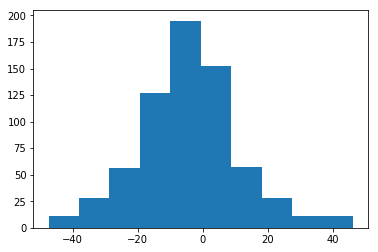

In [53]:
all_systole_high_low, removed, lidx, hidx = removeLowHigh(all_no_outliers_no_zero, 50, 'Systole')
compute_rmse(all_systole_high_low, 'all', val='S')
plt.hist(all_systole_high_low['Systole_diff'])

(694, 8)
(685, 8)
(635, 8)
all Diastole RMSE:  19.801854961574538


(array([ 31.,  53.,  81., 143., 175., 102.,  32.,   6.,   8.,   4.]),
 array([-49.97711917, -40.09227432, -30.20742947, -20.32258462,
        -10.43773977,  -0.55289492,   9.33194993,  19.21679478,
         29.10163963,  38.98648448,  48.87132933]),
 <a list of 10 Patch objects>)

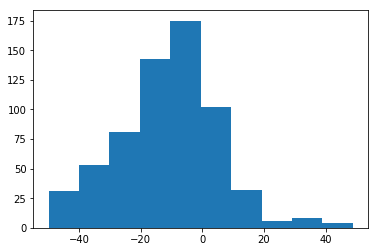

In [54]:
all_diastole_high_low, removed, lidx, hidx = removeLowHigh(all_no_outliers, 50, 'Diastole')
compute_rmse(all_diastole_high_low, 'all', val='D')
plt.hist(all_diastole_high_low['Diastole_diff'])

In [23]:
def compute_rmse(df, source, val = None):
    if val is None:
        sys = np.sqrt(sklearn.metrics.mean_squared_error(df['Systole'],df['Systole_P']))
        dia = np.sqrt(sklearn.metrics.mean_squared_error(df['Diastole'],df['Diastole_P']))
        ef = np.sqrt(sklearn.metrics.mean_squared_error(df['EF'],df['EF_P']))
        print (source,': Systole RMSE: ', sys, 'Diastole RMSE: ', dia, ': EF RMSE: ', ef)
    elif ('D') in val:
        dia = np.sqrt(sklearn.metrics.mean_squared_error(df['Diastole'],df['Diastole_P']))
        print (source,'Diastole RMSE: ', dia)
    elif ('S') in val:
        sys = np.sqrt(sklearn.metrics.mean_squared_error(df['Systole'],df['Systole_P']))
        print (source,': Systole RMSE: ', sys)
    elif ('E') in val:
        ef = np.sqrt(sklearn.metrics.mean_squared_error(df['EF'],df['EF_P']))
        print (source, ': EF RMSE: ', ef)

In [31]:
compute_rmse(train_df, 'Train','D')
compute_rmse(train_df, 'Train', 'S')
compute_rmse(validate_df, 'Validate')
compute_rmse(all_df, 'Train + Validate')
compute_rmse(all_no_outliers, 'Train + Validate - Outliers')

Train Diastole RMSE:  28.959460114248195
Train : Systole RMSE:  20.988483338116882


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [55]:
compute_rmse(all_no_outliers_no_zero, 'Train + Validate - Outliers')

Train + Validate - Outliers : Systole RMSE:  19.905322371857636 Diastole RMSE:  29.126700668582913 : EF RMSE:  0.09256897035550431


In [194]:
# Calculates the RMSE
rmseTrainSystole=np.sqrt(sklearn.metrics.mean_squared_error(train_df['Systole'],train_df['Systole_P']))
rmseTrainDiastole=np.sqrt(sklearn.metrics.mean_squared_error(train_df['Diastole'],train_df['Diastole_P']))
rmseValidateSystole=np.sqrt(sklearn.metrics.mean_squared_error(validate_df['Systole'],validate_df['Systole_P']))
rmseValidateDiastole=np.sqrt(sklearn.metrics.mean_squared_error(validate_df['Diastole'],validate_df['Diastole_P']))
rmseAllSystole=np.sqrt(sklearn.metrics.mean_squared_error(all_df['Systole'],all_df['Systole_P']))
rmseAllDiastole=np.sqrt(sklearn.metrics.mean_squared_error(all_df['Diastole'],all_df['Diastole_P']))
#rmseAllEF=np.sqrt(sklearn.metrics.mean_squared_error(all_df['EF'],all_df['EF_P']))


print ('Train Systole RMSE: ', rmseTrainSystole, 'Train Diastole RMSE: ', rmseTrainDiastole)
print ('Validate Systole RMSE: ', rmseValidateSystole, 'Validate Diastole RMSE: ', rmseValidateDiastole)
print ('Train + Validate Systole RMSE: ', rmseAllSystole, 'Train + Validate Diastole RMSE: ', rmseAllDiastole,
      'Train + Validate Diastole RMSE: ')#, rmseALLEF)

Train Systole RMSE:  21.62053587664091 Train Diastole RMSE:  30.134155137790984
Validate Systole RMSE:  20.705031894767185 Validate Diastole RMSE:  36.35860659092334
Train + Validate Systole RMSE:  21.36296712100584 Train + Validate Diastole RMSE:  32.03621405269209 Train + Validate Diastole RMSE: 


In [195]:
# Plotting Function
def plotting (df, actual, predicted):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[predicted], df[actual],)
    plt.plot(range(len(df[predicted])), range(len(df[actual])), color = 'green')
    plt.xlabel(predicted)
    plt.ylabel(actual)
    plt.xlim(0,600)
    plt.ylim(0, 600)

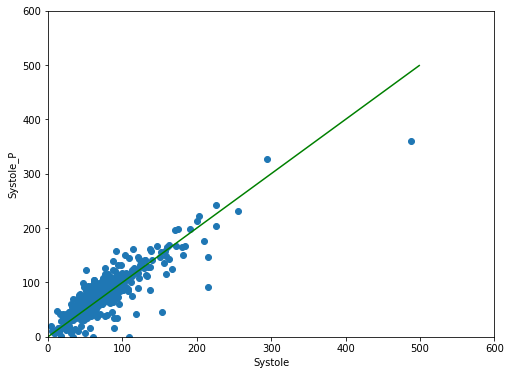

In [196]:
plotting(train_df, actual = 'Systole_P',predicted = 'Systole')

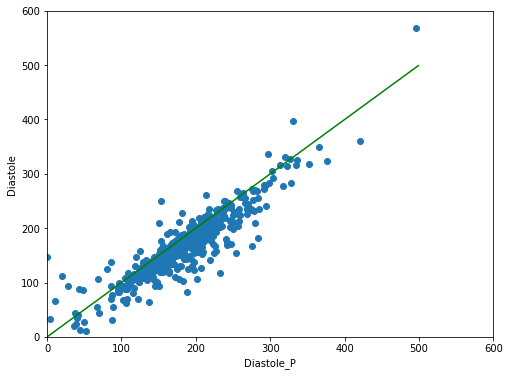

In [197]:
plotting(train_df, actual = 'Diastole',predicted = 'Diastole_P')

In [198]:
all_no_outliers.head()

,Systole,Diastole,Systole_P,Diastole_P,Systole_diff,Diastole_diff,EF_P,EF
Id,,,,,,,,
1,108.3,246.7,106.209699,244.229694,2.090301,2.470306,0.565124,0.561005
2,54.6,137.2,66.754174,144.320024,-12.154174,-7.120024,0.537457,0.602041
3,32.7,99.3,32.978000,108.875000,-0.278000,-9.575000,0.697102,0.670695
4,57.7,154.5,52.003999,177.292994,5.696001,-22.792994,0.706678,0.626537
5,83.3,235.5,89.547040,229.466100,-6.247040,6.033900,0.609759,0.646285


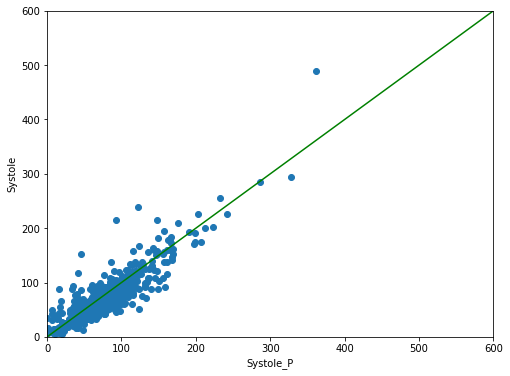

In [175]:
plotting(all_no_outliers_no_zero, actual = 'Systole',predicted = 'Systole_P')

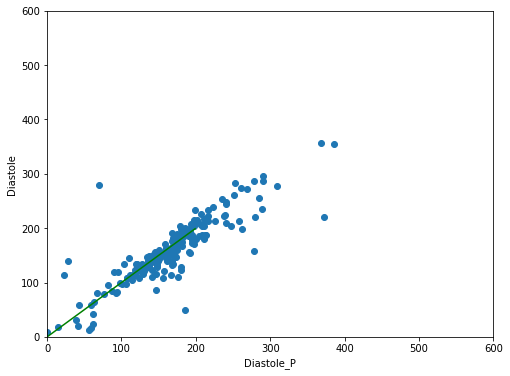

In [139]:
plotting(validate_df, actual = 'Diastole',predicted = 'Diastole_P')

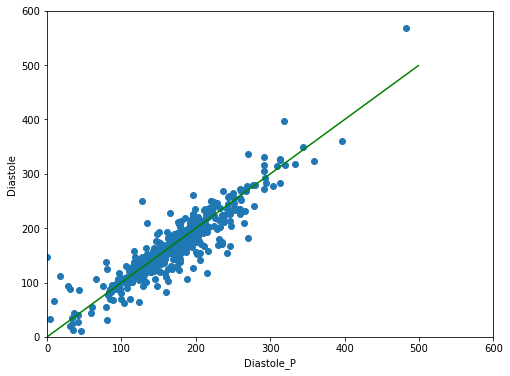

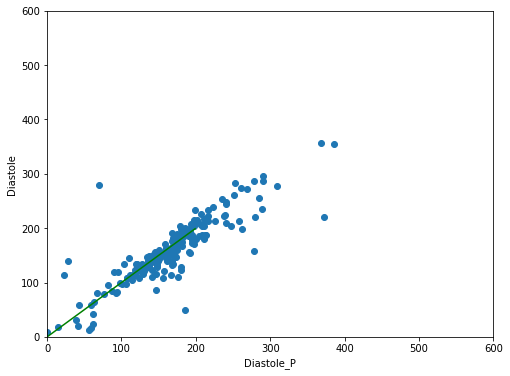

In [140]:
plotting(train_df, actual = 'Diastole',predicted = 'Diastole_P')
plotting(validate_df, actual = 'Diastole',predicted = 'Diastole_P')

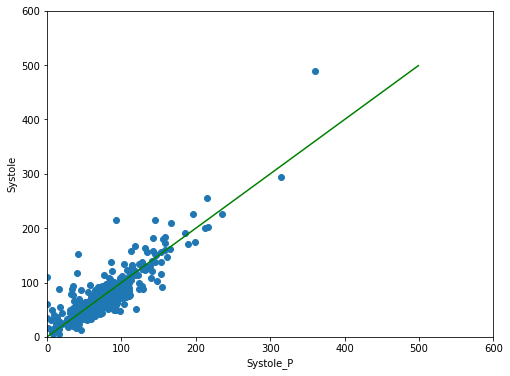

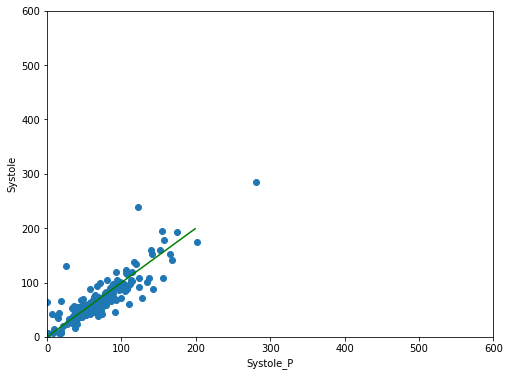

In [141]:
plotting(train_df, actual = 'Systole',predicted = 'Systole_P')
plotting(validate_df, actual = 'Systole',predicted = 'Systole_P')

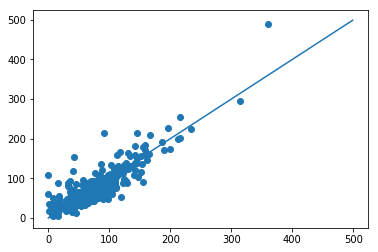

In [142]:
plt.scatter(train_df['Systole_P'],train_df['Systole'])
plt.plot(range(len(train_df['Systole_P'])),range(len(train_df['Systole'])))

In [176]:
# Counts the number of predictions that are higher or lower than the actual value
def estimateCheck (df, actual, predicted, dev):
    diff = df[actual]-df[predicted]
    if dev == 0: 
        low = diff[diff > 0].count()
        correct = diff[diff == 0].count()
        high = diff[diff < 0].count() 
        
    else:
        low = diff[diff > dev].count()
        correct = diff[(diff < 5) & (-5 < diff)].count()
        high = diff[diff < -dev].count()
        
    print ((low/len(df))+(high/len(df))+(correct/len(df)))
    print ('% Low Estimate: ', (low/len(df)), '% Correct Estimate: ', (correct/len(df)),'% High Estimate: ', (high/len(df)))

In [177]:
estimateCheck(all_no_outliers_no_zero, 'Systole','Systole_P', 0)
estimateCheck(all_no_outliers_no_zero, 'Diastole','Diastole_P',0)
estimateCheck(all_no_outliers_no_zero, 'EF','EF_P',0)

1.0
% Low Estimate:  0.3285302593659942 % Correct Estimate:  0.0 % High Estimate:  0.6714697406340058
1.0
% Low Estimate:  0.16714697406340057 % Correct Estimate:  0.0 % High Estimate:  0.8328530259365994
1.0
% Low Estimate:  0.4697406340057637 % Correct Estimate:  0.0 % High Estimate:  0.5302593659942363


In [145]:
estimateCheck(all_no_outliers, 'Systole','Systole_P',5)
estimateCheck(all_no_outliers, 'Diastole','Diastole_P',5)

1.0
% Low Estimate:  0.2564841498559078 % Correct Estimate:  0.3285302593659942 % High Estimate:  0.414985590778098
1.0
% Low Estimate:  0.33861671469740634 % Correct Estimate:  0.2276657060518732 % High Estimate:  0.43371757925072046


In [146]:
estimateCheck(all_systole_high_low, 'Systole','Systole_P',5)
estimateCheck(all_diastole_high_low, 'Systole','Systole_P',5)

1.0
% Low Estimate:  0.24742268041237114 % Correct Estimate:  0.33578792341678937 % High Estimate:  0.4167893961708395
1.0
% Low Estimate:  0.25306748466257667 % Correct Estimate:  0.34355828220858897 % High Estimate:  0.40337423312883436
